In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import string
import os

py_path = os.path.join(os.path.dirname(os.getcwd()),"markdown_predictions")
sys.path.insert(0,py_path)
from parse_data import LoadSalesData

# Load the data

In [2]:
JSON_PATH = os.path.join(os.path.dirname(os.getcwd()),"markdown_predictions")

In [3]:
loaded_data = LoadSalesData.load_in_files("../raw_data")
df = loaded_data.sales_data

In [4]:
df.head(5)

,delivery_PRE,window_display_PRE,target_PRE,gender_PRE,product_category_PRE,family_PRE,sub_family_PRE,macro_category_PRE,reference_name_PRE,reference_PRE,...,cum_quantity_sold_POST,num_sizes_POST,num_stores_POST,first_week_sale_POST,rate_of_sale_POST,cum_sellthrough_POST,warehouse_stock_POST,zero_stock_POST,avail_warehouse_stock_POST,%_POST
0,PERM SELECTIF EARLY SEASON,PERM S VET EARLY ADF_JOUR PERM,3-ADULTE,FE,JOUR,FA GROSSES PIECES VET,"CIRES, COUPE VENT VET",Adulte Jour,CIRE,5246101.0,...,"3,012",7,137,2019-S28,0.76,98 %,0,0,0,0%
1,PERM SELECTIF EARLY SEASON,PERM S VET EARLY ADF_JOUR PERM,3-ADULTE,FE,JOUR,FA GROSSES PIECES VET,"CIRES, COUPE VENT VET",Adulte Jour,CIRE,5246102.0,...,"2,930",7,136,2019-S28,0.74,99 %,0,0,0,0%
2,AH2019 SELECTIF PREVIEW,19 S VET N-SV_PARIS,2-ENFANT,FE,NUIT,FA PYJAMAS VET,SF PYJALONG,Enfant Nuit,COPARIS,5225401.0,...,"6,196",8,169,2019-S28,1.26,100 %,0,0,0,0%
3,AH2019 SELECTIF HIGH SEASON,19 S VET HIGH JRENF_ICED WINTE,2-ENFANT,FE,JOUR,FA ROBES VET,ROBES ML VET,Enfant Jour,CORAIL,4958901.0,...,"3,647",7,170,2019-S35,0.98,95 %,0,0,0,20%
4,AH2019 SELECTIF HIGH SEASON,19 S VET HIGH N-SV_FESTIVE SEA,2-ENFANT,MA,NUIT,FA PYJAMAS VET,SF PYJALONG,Enfant Nuit,CHATEAU,5105201.0,...,"3,248",8,169,2019-S43,1.01,86 %,0,0,0,20%


In [5]:
df.columns

Index(['delivery_PRE', 'window_display_PRE', 'target_PRE', 'gender_PRE',
       'product_category_PRE', 'family_PRE', 'sub_family_PRE',
       'macro_category_PRE', 'reference_name_PRE', 'reference_PRE',
       'description_PRE', 'color_PRE', 'material_PRE', 'seasonality_PRE',
       'price_PRE', 'weekly_rank_PRE', 'turnover_PRE', 'sub_target_PRE',
       'turnover_w_sub1_PRE', 'turnover_w_sub2_PRE', 'turnover_w_sub3_PRE',
       'quantity_sold_PRE', 'quantity_sold_sub1_PRE', 'quantity_sold_sub2_PRE',
       'quantity_sold_sub3_PRE', 'discount_rate_PRE', 'discount_rate_sub1_PRE',
       'store_stock_PRE', 'stock_transit_PRE', 'total_store_stock_PRE',
       'weekly_cover_PRE', 'cum_turnover_PRE', 'cum_discount_rate_PRE',
       'cum_quantity_sold_PRE', 'num_sizes_PRE', 'num_stores_PRE',
       'first_week_sale_PRE', 'rate_of_sale_PRE', 'cum_sellthrough_PRE',
       'warehouse_stock_PRE', 'zero_stock_PRE', 'avail_warehouse_stock_PRE',
       '%_PRE', 'season_PRE', 'reference_POST', 'sea

# Clean data

In [6]:
df.replace('-', np.nan, inplace=True)
df.dropna(inplace=True)

In [7]:
def replace_commas(x):
    x = x.replace(",",".")
    return x

def remove_commas(x):
    x = x.replace(",","")
    return x

def remove_symbols(x):
    symbols = ['€','%']
    for symbol in symbols:
        x = x.replace(symbol,"")
    return x

## Replace price commas with decimals & convert

In [8]:
df['price_PRE'] = df['price_PRE'].apply(replace_commas)
df['price_PRE'] = df['price_PRE'].astype(float)
df['price_POST'] = df['price_POST'].apply(replace_commas)
df['price_POST'] = df['price_POST'].astype(float)

## Remove commas, remove symbols, & convert numeric features

In [9]:
'family_PRE','gender_PRE','macro_category_PRE'

('family_PRE', 'gender_PRE', 'macro_category_PRE')

In [10]:
for col in df.columns:
    try:
        df[col] = df[col].apply(remove_commas)
        df[col] = df[col].apply(remove_symbols)
    except AttributeError:
        pass
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        print(f'leaving {col} as type string')

leaving delivery_PRE as type string
leaving window_display_PRE as type string
leaving target_PRE as type string
leaving gender_PRE as type string
leaving product_category_PRE as type string
leaving family_PRE as type string
leaving sub_family_PRE as type string
leaving macro_category_PRE as type string
leaving reference_name_PRE as type string
leaving reference_PRE as type string
leaving description_PRE as type string
leaving color_PRE as type string
leaving material_PRE as type string
leaving seasonality_PRE as type string
leaving sub_target_PRE as type string
leaving first_week_sale_PRE as type string
leaving season_PRE as type string
leaving reference_POST as type string
leaving seasonality_POST as type string
leaving first_week_sale_POST as type string


## Deal with week of first sale, convert to datetime

In [11]:
def remove_s(x):
    x = x.replace('S','')
    return x

def add_monday(x):
    x = x + 'Mon'
    return x

In [12]:
df['first_week_sale_POST'] = df['first_week_sale_POST'].apply(remove_s)
df['first_week_sale_PRE'] = df['first_week_sale_PRE'].apply(remove_s)
df['first_week_sale_POST'] = df['first_week_sale_POST'].apply(add_monday)
df['first_week_sale_PRE'] = df['first_week_sale_PRE'].apply(add_monday)

In [13]:
df['first_week_sale_PRE'] = pd.to_datetime(df['first_week_sale_PRE'],errors='coerce',format='%Y-%U%a')
df['first_week_sale_POST'] = pd.to_datetime(df['first_week_sale_POST'],errors='coerce',format='%Y-%U%a')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6078 entries, 3 to 12926
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   delivery_PRE                6078 non-null   object        
 1   window_display_PRE          6078 non-null   object        
 2   target_PRE                  6078 non-null   object        
 3   gender_PRE                  6078 non-null   object        
 4   product_category_PRE        6078 non-null   object        
 5   family_PRE                  6078 non-null   object        
 6   sub_family_PRE              6078 non-null   object        
 7   macro_category_PRE          6078 non-null   object        
 8   reference_name_PRE          6078 non-null   object        
 9   reference_PRE               6078 non-null   object        
 10  description_PRE             6078 non-null   object        
 11  color_PRE                   6078 non-null   object     

# Correlations

In [15]:
df['sales_after_markdown'] = df['quantity_sold_POST'] + df['quantity_sold_sub1_POST']

In [16]:
df.corr()

,price_PRE,weekly_rank_PRE,turnover_PRE,turnover_w_sub1_PRE,turnover_w_sub2_PRE,turnover_w_sub3_PRE,quantity_sold_PRE,quantity_sold_sub1_PRE,quantity_sold_sub2_PRE,quantity_sold_sub3_PRE,...,cum_quantity_sold_POST,num_sizes_POST,num_stores_POST,rate_of_sale_POST,cum_sellthrough_POST,warehouse_stock_POST,zero_stock_POST,avail_warehouse_stock_POST,%_POST,sales_after_markdown
price_PRE,1.000000,-0.207295,0.227817,0.194508,0.240243,0.209185,-0.109849,-0.097297,-0.077142,-0.077509,...,-0.165019,0.006569,-0.106617,-0.041266,-0.078640,-0.027175,NaN,-0.025406,0.191749,-0.081561
weekly_rank_PRE,-0.207295,1.000000,-0.756759,-0.603585,-0.579521,-0.528958,-0.724821,-0.541358,-0.504573,-0.473900,...,-0.605088,-0.226361,-0.535466,0.084605,-0.213531,-0.064845,NaN,-0.063867,0.062737,-0.512708
turnover_PRE,0.227817,-0.756759,1.000000,0.745543,0.654160,0.624610,0.841432,0.567387,0.456991,0.475455,...,0.520070,0.206217,0.364898,-0.045526,0.187414,0.039921,NaN,0.041593,-0.061406,0.420466
turnover_w_sub1_PRE,0.194508,-0.603585,0.745543,1.000000,0.814308,0.774613,0.603328,0.859036,0.645627,0.631006,...,0.457678,0.195460,0.311398,-0.034379,0.183933,-0.078023,NaN,-0.079718,-0.085030,0.348855
turnover_w_sub2_PRE,0.240243,-0.579521,0.654160,0.814308,1.000000,0.673758,0.525323,0.672821,0.851362,0.544984,...,0.487164,0.201966,0.316610,-0.037395,0.202589,-0.056869,NaN,-0.059078,-0.014946,0.370869
turnover_w_sub3_PRE,0.209185,-0.528958,0.624610,0.774613,0.673758,1.000000,0.500595,0.628813,0.502547,0.860962,...,0.469421,0.187085,0.304834,-0.040811,0.172194,-0.071756,NaN,-0.074323,-0.059753,0.311636
quantity_sold_PRE,-0.109849,-0.724821,0.841432,0.603328,0.525323,0.500595,1.000000,0.656171,0.544470,0.547679,...,0.663981,0.223758,0.428308,-0.045707,0.226859,0.047820,NaN,0.048945,-0.140086,0.504688
quantity_sold_sub1_PRE,-0.097297,-0.541358,0.567387,0.859036,0.672821,0.628813,0.656171,1.000000,0.746030,0.697271,...,0.562203,0.219787,0.342717,-0.034007,0.206247,-0.093696,NaN,-0.096797,-0.156550,0.414094
quantity_sold_sub2_PRE,-0.077142,-0.504573,0.456991,0.645627,0.851362,0.502547,0.544470,0.746030,1.000000,0.581786,...,0.585713,0.214235,0.348680,-0.033875,0.226761,-0.058224,NaN,-0.062470,-0.073228,0.437246
quantity_sold_sub3_PRE,-0.077509,-0.473900,0.475455,0.631006,0.544984,0.860962,0.547679,0.697271,0.581786,1.000000,...,0.586406,0.192225,0.350509,-0.032043,0.198155,-0.065453,NaN,-0.069954,-0.115610,0.367581


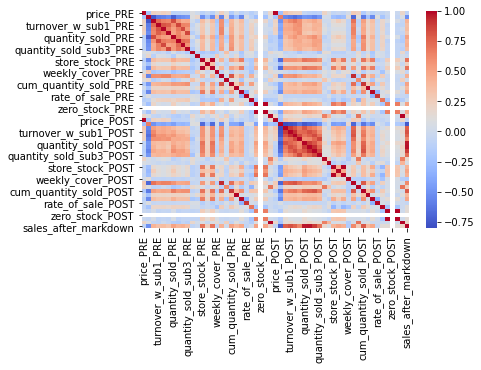

In [17]:
sns.heatmap(df.corr(), cmap='coolwarm');

## Split into PRE & POST

In [18]:
pre_columns = []
post_columns = []
for col in df.columns:
    if col[-1] == 'E':
        pre_columns.append(col)
    if col[-1] == 'T':
        post_columns.append(col)

In [19]:
pre_df = df[pre_columns]
post_df = df[post_columns]

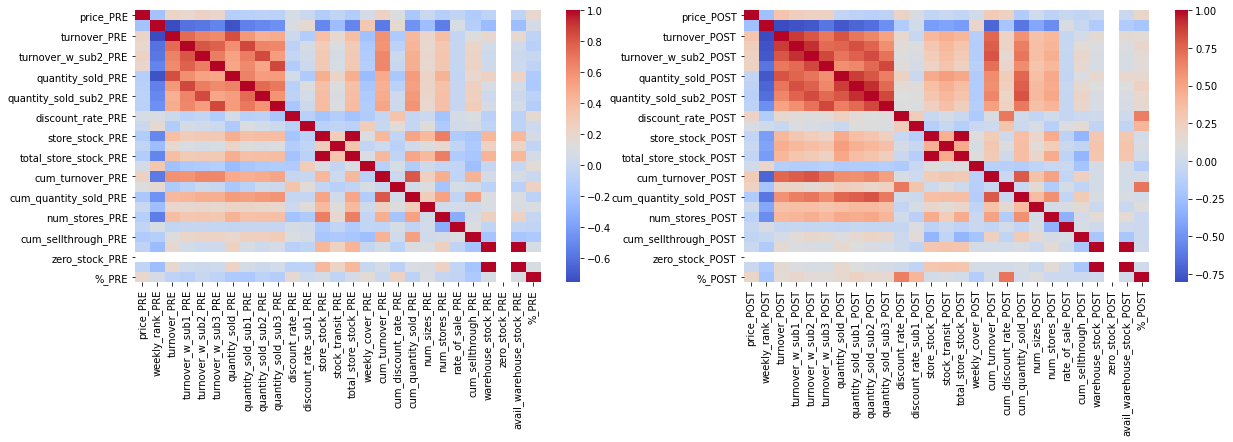

In [20]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.heatmap(pre_df.corr(), cmap='coolwarm')

plt.subplot(1,2,2)
sns.heatmap(post_df.corr(), cmap='coolwarm');

<AxesSubplot:xlabel='discount_rate_PRE', ylabel='%_PRE'>

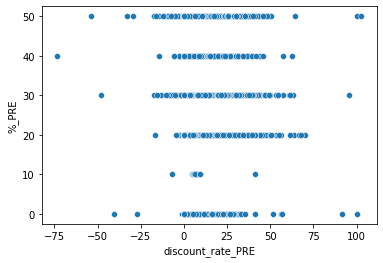

In [21]:
sns.scatterplot(x=df['discount_rate_PRE'],y=df['%_PRE'])

(-5.0, 52.609729342135765)

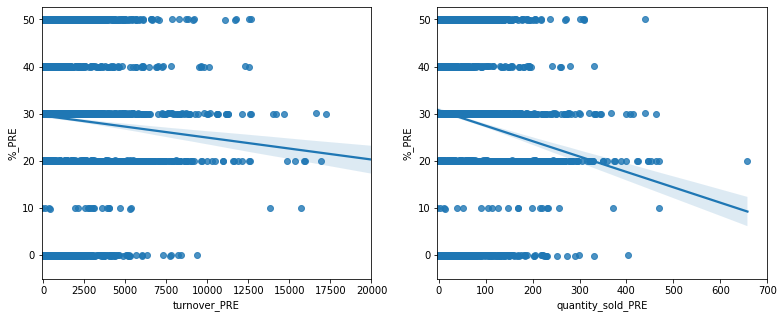

In [22]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['turnover_PRE'], y = df['%_PRE'], y_jitter=.1)
plt.xlim(right=20_000)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['quantity_sold_PRE'], y= df['%_PRE'], y_jitter=.1)
plt.xlim(right=700)
plt.ylim(bottom=-5)

(-5.0, 55.30603200149166)

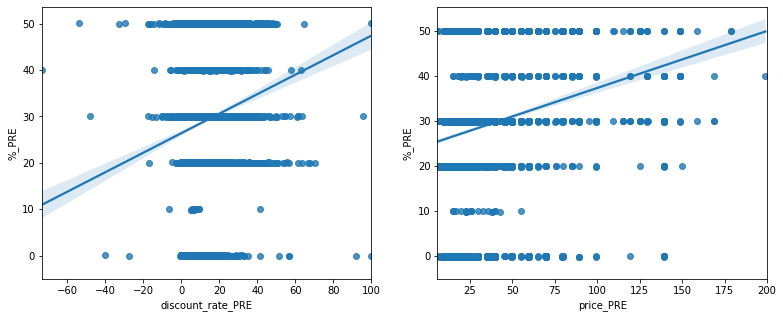

In [23]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['discount_rate_PRE'], y = df['%_PRE'], y_jitter=.1)
plt.xlim(right=100)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['price_PRE'], y= df['%_PRE'], y_jitter=.1)
plt.xlim(right=200)
plt.ylim(bottom=-5)

# Statsmodels

In [24]:
import statsmodels.formula.api as smf

In [25]:
def compute_rmse(pred,actual):
    diff = pred - actual
    rmse = (((diff) ** 2).mean() ** 0.5)
    return rmse

## Markdown

In [26]:
df['markdown_PRE'] = df['%_PRE']
df['markdown_POST'] = df['%_POST']

In [27]:
model1 = smf.ols(formula = 'markdown_PRE ~ discount_rate_PRE + price_PRE', data = df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     203.2
Date:                Thu, 26 Aug 2021   Prob (F-statistic):           3.89e-86
Time:                        18:38:10   Log-Likelihood:                -24450.
No. Observations:                6078   AIC:                         4.891e+04
Df Residuals:                    6075   BIC:                         4.893e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6945      0.357     63.487      0.000      21.994      23.395
discount_rate_PRE     0.1934      0.015     12.963      0.000       0.164       0.223
price_PRE             0.1182      0.008     14.364      0.000       0.102       0.134
==============================================================================
Omnibus:                       44.188   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.032
Skew:                          -0.211   Prob(JB):                     1.66e-10
Kurtosis:                       3.006   Cond. No.                         84.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
markdown_pred1 = model1.predict()

In [29]:
model2 = smf.ols(formula = 'markdown_PRE ~ turnover_PRE + gender_PRE', data = df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     97.32
Date:                Thu, 26 Aug 2021   Prob (F-statistic):           1.59e-61
Time:                        18:38:11   Log-Likelihood:                -24504.
No. Observations:                6078   AIC:                         4.902e+04
Df Residuals:                    6074   BIC:                         4.904e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           31.7527      0.330     96.212      0.000      31.106      32.400
gender_PRE[T.MA]     1.0121      0.443      2.283      0.022       0.143       1.881
gender_PRE[T.MI]    -5.6518      0.414    -13.660      0.000      -6.463      -4.841
turnover_PRE        -0.0008   9.67e-05     -7.792      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       53.563   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.319
Skew:                          -0.223   Prob(JB):                     1.60e-12
Kurtosis:                       2.878   Cond. No.                     7.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
markdown_pred2 = model2.predict()

In [31]:
model3 = smf.ols(formula = 'markdown_PRE ~ first_week_sale_PRE', data = df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           markdown_PRE   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.931
Date:                Thu, 26 Aug 2021   Prob (F-statistic):          1.85e-116
Time:                        18:38:16   Log-Likelihood:                -24171.
No. Observations:                6078   AIC:                         4.863e+04
Df Residuals:                    5932   BIC:                         4.961e+04
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  40.0000      6.533      6.123      0.000      27.192      52.808
first_week_sale_PRE[T.Timestamp('2017-12-18 00:00:00')] -1.218e-13      8.190  -1.49e-14      1.000     -16.055      16.055
first_week_sale_PRE[T.Timestamp('2017-12-25 00:00:00')]    -8.3333      8.434     -0.988      0.323     -24.868       8.201
first_week_sale_PRE[T.Timestamp('2018-01-08 00:00:00')]     0.4545      6.728      0.068      0.946     -12.735      13.645
first_week_sale_PRE[T.Timestamp('2018-01-15 00:00:00')]     3.3333      7.852      0.425      0.671     -12.059      18.726
first_week_sale_PRE[T.Timestamp('2018-01-22 00:00:00')]    -0.2000      6.790     -0.029      0.977     -13.510      13.110
first_week_sale_PRE[T.Timestamp('2018-01-29 00:00:00')]   -12.7632      6.703     -1.904      0.057     -25.903       0.377
first_week_sale_PRE[T.Timestamp('2018-02-05 00:00:00')]    -5.4839      6.741     -0.814      0.416     -18.698       7.730
first_week_sale_PRE[T.Timestamp('2018-02-12 00:00:00')]    -9.7260      6.710     -1.450      0.147     -22.880       3.428
first_week_sale_PRE[T.Timestamp('2018-02-19 00:00:00')]    -8.4615      6.731     -1.257      0.209     -21.657       4.734
first_week_sale_PRE[T.Timestamp('2018-02-26 00:00:00')]    -0.3704      7.001     -0.053      0.958     -14.094      13.353
first_week_sale_PRE[T.Timestamp('2018-03-05 00:00:00')]   -14.0000      6.955     -2.013      0.044     -27.635      -0.365
first_week_sale_PRE[T.Timestamp('2018-03-12 00:00:00')]   -10.0000      7.852     -1.274      0.203     -25.393       5.393
first_week_sale_PRE[T.Timestamp('2018-03-19 00:00:00')]   -19.5833      7.057     -2.775      0.006     -33.417      -5.750
first_week_sale_PRE[T.Timestamp('2018-03-26 00:00:00')]   -12.9114      6.697     -1.928      0.054     -26.039       0.216
first_week_sale_PRE[T.Timestamp('2018-04-02 00:00:00')]   -16.0000      6.790     -2.357      0.018     -29.310      -2.690
first_week_sale_PRE[T.Timestamp('2018-04-09 00:00:00')]   -16.4865      6.877     -2.397      0.017     -29.969      -3.004
first_week_sale_PRE[T.Timestamp('2018-04-16 00:00:00')]   -15.2941      7.261     -2.106      0.035     -29.529      -1.059
first_week_sale_PRE[T.Timestamp('2018-04-23 00:00:00')]   -13.4375      6.930     -1.939      0.053     -27.022       0.147
first_week_sale_PRE[T.Timestamp('2018-04-30 00:00:00')]   -40.0000     14.609     -2.738      0.006     -68.639     -11.361
first_week_sale_PRE[T.Timestamp('2018-05-07 00:00:00')]   -35.0000      9.239     -3.788      0.000     -53.113     -16.887
first_week_sale_PRE[T.Timestamp('2018-05-21 00:00:00')]   -23.3333      9.980     -2.338      0.019     -42

In [32]:
markdown_pred3 = model3.predict()

### Markdown baseline compare

RMSE may not be the best metric for predicting this, as markdowns fall into one of 6 options (0, 10, 20, 30, 40, 50). The target seems categorical, but categories are also ranked.  

In [33]:
df['markdown_PRE'].mean()

28.89437314906219

In [34]:
markdown_baseline = compute_rmse(df['markdown_PRE'].mean(),df['markdown_PRE'])
markdown_baseline

13.959291798037151

In [35]:
md_rmse1 = compute_rmse(markdown_pred1,df['markdown_PRE'])
md_rmse1

13.514628273298944

In [36]:
md_rmse2 = compute_rmse(markdown_pred2,df['markdown_PRE'])
md_rmse2

13.635420759702217

In [37]:
md_rmse3 = compute_rmse(markdown_pred3,df['markdown_PRE'])
md_rmse3

12.908637076432063

After reviewing the markdown models and due to the ranked/categorical nature of the markdowns, we have decided to move forward with a model to predict sales instead of the markdown.

## Sales

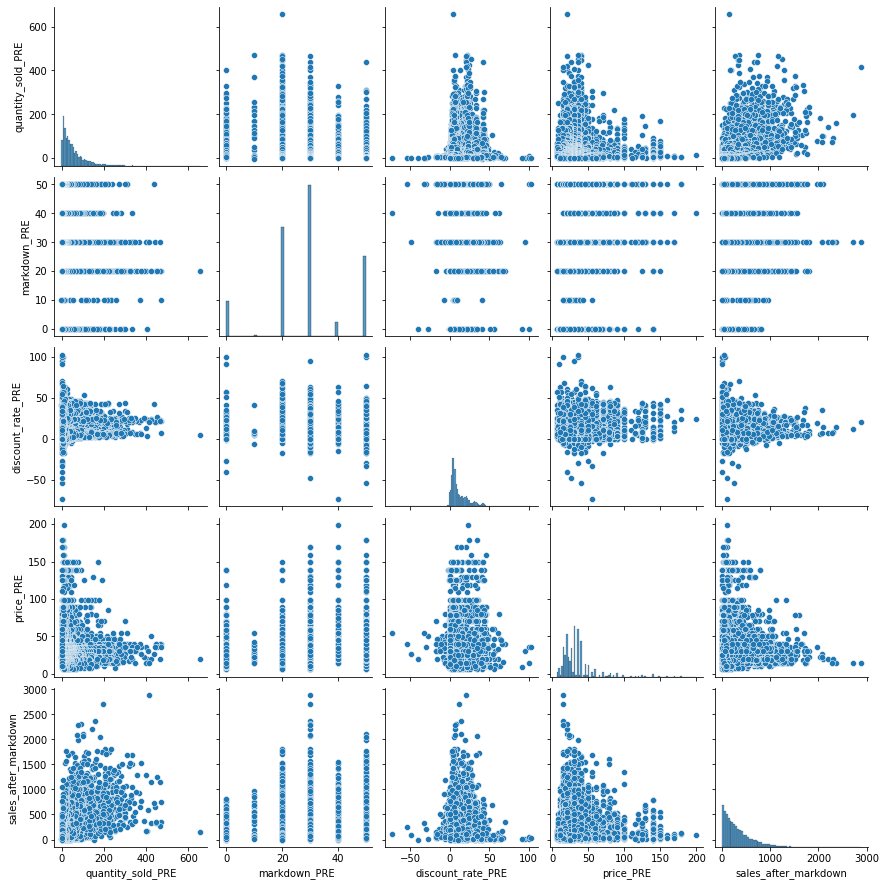

In [38]:
sns.pairplot(df[['first_week_sale_PRE','quantity_sold_PRE','markdown_PRE','discount_rate_PRE','price_PRE','sales_after_markdown']])

(-100.0, 3025.15)

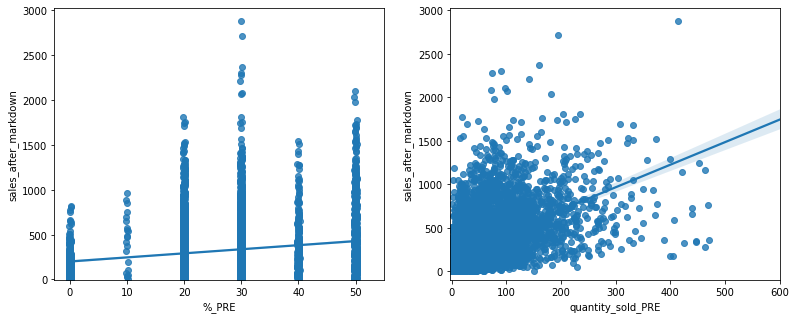

In [39]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['%_PRE'], y = df['sales_after_markdown'], x_jitter=.2)
plt.xlim(right=55)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['quantity_sold_PRE'], y= df['sales_after_markdown'])
plt.xlim(right=600)
plt.ylim(bottom=-100)

(-100.0, 3025.15)

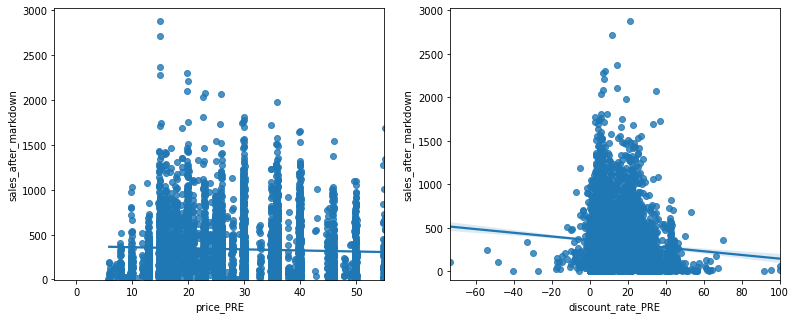

In [40]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = df['price_PRE'], y = df['sales_after_markdown'], x_jitter=.2)
plt.xlim(right=55)
plt.ylim(bottom=-5)

plt.subplot(1,2,2)
sns.regplot(x = df['discount_rate_PRE'], y= df['sales_after_markdown'])
plt.xlim(right=100)
plt.ylim(bottom=-100)

In [41]:
sales_model = smf.ols(formula = 'sales_after_markdown ~ quantity_sold_PRE + markdown_PRE + gender_PRE + weekly_cover_PRE + product_category_PRE', data = df).fit()
sales_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     sales_after_markdown   R-squared:                       0.371
Model:                              OLS   Adj. R-squared:                  0.370
Method:                   Least Squares   F-statistic:                     357.6
Date:                  Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                          18:38:36   Log-Likelihood:                -42054.
No. Observations:                  6078   AIC:                         8.413e+04
Df Residuals:                      6067   BIC:                         8.420e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -57.8502     13.249     -4.367      0.000     -83.822     -31.878
gender_PRE[T.MA]                        52.8954      8.134      6.503      0.000      36.949      68.842
gender_PRE[T.MI]                       -29.7863      8.561     -3.479      0.001     -46.569     -13.004
product_category_PRE[T.AISV]            71.0270     15.120      4.698      0.000      41.387     100.667
product_category_PRE[T.JOUR]            90.2441     12.069      7.477      0.000      66.584     113.904
product_category_PRE[T.NUIT]            68.1231     11.709      5.818      0.000      45.170      91.076
product_category_PRE[T.PUERICULTURE]    31.6219     25.064      1.262      0.207     -17.512      80.756
product_category_PRE[T.SS VET]         165.0379     13.385     12.331      0.000     138.799     191.276
quantity_sold_PRE                        2.6581      0.055     48.021      0.000       2.550       2.767
markdown_PRE                             5.3595      0.249     21.496      0.000       4.871       5.848
weekly_cover_PRE                         0.0575      0.028      2.043      0.041       0.002       0.113
==============================================================================
Omnibus:                     1914.546   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11944.373
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       9.306   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Sales baseline compare

In [42]:
y_baseline = df['sales_after_markdown'].mean()
y_pred = sales_model.predict()

In [43]:
compute_rmse(y_pred,df['sales_after_markdown'])

244.71089244727094

In [44]:
compute_rmse(y_baseline,df['sales_after_markdown'])

308.50490264014417

# Scale data and run feature selection models

In [45]:
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.preprocessing import RobustScaler,OneHotEncoder

In [46]:
post_cols = []
for col in df.columns:
    if col[-1] == 'T':
        post_cols.append(col)
post_cols
post_df = df[post_cols+['family_PRE','gender_PRE','macro_category_PRE']]

In [47]:
post_df = post_df.drop('%_POST', axis=1)
post_df['sales_after_markdown'] = df['sales_after_markdown']

In [48]:
post_df

,reference_POST,seasonality_POST,price_POST,weekly_rank_POST,turnover_POST,turnover_w_sub1_POST,turnover_w_sub2_POST,turnover_w_sub3_POST,quantity_sold_POST,quantity_sold_sub1_POST,...,rate_of_sale_POST,cum_sellthrough_POST,warehouse_stock_POST,zero_stock_POST,avail_warehouse_stock_POST,markdown_POST,family_PRE,gender_PRE,macro_category_PRE,sales_after_markdown
3,4958901.0,Hiver,49.9,392.0,3558.0,5267.0,5244.0,6008.0,150.0,174.0,...,0.98,95.0,0.0,0.0,0.0,20.0,FA ROBES VET,FE,Enfant Jour,324.0
4,5105201.0,Hiver,39.9,244.0,4989.0,6524.0,7384.0,7441.0,163.0,195.0,...,1.01,86.0,0.0,0.0,0.0,20.0,FA PYJAMAS VET,MA,Enfant Nuit,358.0
5,5257801.0,Hiver,39.9,385.0,3629.0,5629.0,6161.0,5899.0,115.0,165.0,...,0.96,85.0,0.0,0.0,0.0,20.0,FA CHEMISE DE NUIT,FE,Enfant Nuit,280.0
6,5105101.0,Hiver,39.9,319.0,4145.0,6872.0,5290.0,6767.0,133.0,204.0,...,0.92,81.0,3.0,0.0,3.0,20.0,FA PYJAMAS VET,MA,Enfant Nuit,337.0
7,5104801.0,Hiver,39.9,283.0,4469.0,6750.0,5800.0,7033.0,146.0,201.0,...,0.87,85.0,0.0,0.0,0.0,20.0,FA PYJAMAS VET,FE,Enfant Nuit,347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12917,4310488.0,Eté,24.9,1277.0,38.0,51.0,127.0,1555.0,3.0,3.0,...,6.10,96.0,0.0,0.0,0.0,30.0,FA PYJAMAS VET,FE,Enfant Nuit,6.0
12920,4319155.0,Eté,34.9,1067.0,775.0,815.0,425.0,1254.0,41.0,39.0,...,5.12,67.0,0.0,0.0,0.0,40.0,FA COMBINAISONS VET,MA,Bébé Debout,80.0
12921,4314805.0,Eté,24.9,1287.0,20.0,0.0,-20.0,15.0,1.0,0.0,...,2.14,98.0,0.0,0.0,0.0,20.0,FA PYJAMAS VET,MA,Enfant Nuit,1.0
12922,2753175.0,Eté,29.9,1074.0,754.0,551.0,217.0,492.0,42.0,26.0,...,0.84,56.0,28.0,0.0,14.0,30.0,FA CACHCOEUR+CARD.+GILET J VET,FE,Bébé Debout,68.0


In [49]:
y = post_df.pop('sales_after_markdown')

In [50]:
X = post_df

In [51]:
y.shape,X.shape

((6078,), (6078, 33))

In [52]:
df['macro_category_PRE'].unique()

array(['Enfant Jour', 'Enfant Nuit', 'Enfant Sous-Vêt', 'Adulte Jour',
       'Bébé Debout', 'Bébé Sous-Vêt', 'Bébé Nuit', 'Adulte T-Shirt',
       'Bébé couché', 'Adulte Sous-Vêt'], dtype=object)

In [53]:
X_num = X.drop(columns=['family_PRE',
                        'gender_PRE',
                        'macro_category_PRE',
                        'reference_POST',
                        'seasonality_POST',
                        'first_week_sale_POST',
                        'quantity_sold_POST',
                        'quantity_sold_sub1_POST',
                        'turnover_POST',
                        'turnover_w_sub1_POST'])

In [54]:
X_cat = X[['family_PRE','gender_PRE','macro_category_PRE']]

In [55]:
scaler = RobustScaler()
X_num_scaled = scaler.fit_transform(X_num)

In [56]:
ohe = OneHotEncoder()
X_cat_encoded = ohe.fit_transform(X_cat)

In [57]:
ridge_model = Ridge()
ridge_model.fit(X_num_scaled,y)

Ridge()

In [58]:
ridge_model.coef_

array([-1.16017853e+01, -1.28666114e+02, -2.56453006e+01, -2.25193881e+01,
        2.62259004e+02, -2.81636152e+01,  3.71315934e+01, -4.80270392e+00,
        8.17135460e+00,  2.16138117e+01,  8.51062229e+00, -4.79778227e-01,
        1.60419952e+00,  4.59420420e+01,  6.12948682e+01, -3.85415037e+00,
       -2.43189246e+01, -1.70591571e-01, -9.13795456e-01,  7.34779531e+00,
        0.00000000e+00, -7.08256484e+00, -1.22110738e+01])

In [59]:
lasso_model = Lasso()
lasso_model.fit(X_num_scaled,y)

Lasso()

In [60]:
linear_model = LinearRegression()
linear_model.fit(X_num_scaled,y)

LinearRegression()

In [61]:
lasso_coefs = pd.DataFrame({"coef_lasso":pd.Series(lasso_model.coef_,index=X_num.columns),
                            "coef_ridge":pd.Series(ridge_model.coef_,index=X_num.columns),
                            "linearModel":pd.Series(linear_model.coef_,index=X_num.columns)})
lasso_coefs = lasso_coefs.round(decimals=3)
lasso_coefs.sort_values(by='coef_lasso')

,coef_lasso,coef_ridge,linearModel
weekly_rank_POST,-118.696,-128.666,-128.823
turnover_w_sub3_POST,-40.337,-22.519,-21.845
num_stores_POST,-12.759,-24.319,-24.392
price_POST,-10.161,-11.602,-11.611
markdown_POST,-8.717,-12.211,-12.258
quantity_sold_sub3_POST,-5.316,-28.164,-28.950
discount_rate_sub1_POST,-4.781,-4.803,-4.804
weekly_cover_POST,-0.571,-0.480,-0.478
rate_of_sale_POST,-0.029,-0.171,-0.171
avail_warehouse_stock_POST,0.000,-7.083,-7.376


In [62]:
X_num2 = X_num.drop(columns=['zero_stock_POST',
                           'cum_quantity_sold_POST',
                           'quantity_sold_sub2_POST',
                           'weekly_rank_POST',
                           'turnover_w_sub3_POST',
                           'discount_rate_POST'])

In [63]:
scaler2 = RobustScaler()
X_num2_scaled = scaler2.fit_transform(X_num2)

In [64]:
baseline = np.array([df['sales_after_markdown'].mean()]*len(y))

# Cross Validation

In [65]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [66]:
result = cross_validate(Lasso(),X_num_scaled,y,scoring=['neg_mean_absolute_error','neg_root_mean_squared_error','r2'],cv=5)
print('absolute_error:', result['test_neg_mean_absolute_error'].mean())
print(f'rmse: {result["test_neg_root_mean_squared_error"].mean()}')
print(f'r2: {result["test_r2"].mean()}')

absolute_error: -74.03216789141725
rmse: -112.6331774018009
r2: 0.8568790685416738


In [67]:
result2 = cross_validate(Ridge(),X_num_scaled,y,scoring=['neg_mean_absolute_error','neg_root_mean_squared_error','r2'],cv=5)
print(f"absolute_error: {result2['test_neg_mean_absolute_error'].mean()}")
print(f"rmse: {result2['test_neg_root_mean_squared_error'].mean()}")
print(f"r2: {result2['test_r2'].mean()}")

absolute_error: -75.35648750399773
rmse: -113.95118720043563
r2: 0.8522707498048263


In [68]:
result3 = cross_validate(LinearRegression(),X_num_scaled,y,scoring=['neg_mean_absolute_error','neg_root_mean_squared_error','r2'],cv=5)
print(f"absolute_error: {result3['test_neg_mean_absolute_error'].mean()}")
print(f"rmse: {result3['test_neg_root_mean_squared_error'].mean()}")
print(f"r2: {result3['test_r2'].mean()}")

absolute_error: -75.38631273453707
rmse: -113.97460147776289
r2: 0.8521970403657934


In [69]:
mean_squared_error(baseline,y) ** .5

308.50490264014417

In [70]:
result4 = cross_validate(LinearRegression(),X_num2_scaled,y,scoring=['neg_mean_absolute_error','neg_root_mean_squared_error','r2'],cv=5)
print(f"absolute_error: {result4['test_neg_mean_absolute_error'].mean()}")
print(f"rmse: {abs(result4['test_neg_root_mean_squared_error'].mean())}")
print(f"r2: {result4['test_r2'].mean()}")

absolute_error: -99.13862719727675
rmse: 153.84454177638023
r2: 0.7350435773857701


In [71]:
X_num2.columns

Index(['price_POST', 'turnover_w_sub2_POST', 'quantity_sold_sub3_POST',
       'discount_rate_sub1_POST', 'store_stock_POST', 'stock_transit_POST',
       'total_store_stock_POST', 'weekly_cover_POST', 'cum_turnover_POST',
       'cum_discount_rate_POST', 'num_sizes_POST', 'num_stores_POST',
       'rate_of_sale_POST', 'cum_sellthrough_POST', 'warehouse_stock_POST',
       'avail_warehouse_stock_POST', 'markdown_POST'],
      dtype='object')